# 3-1. 프로젝트 : 폐렴 진단기 성능개선

In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


### Step 1. 실험환경 Set-up

##### 패키지(라이브러리)들을 import

In [2]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

##### 변경 해볼 파라미터 : Batch size, Epoch
- BATCH_SIZE : 16 > 32
- EPOCHS = 10 > 15

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 15

print(ROOT_PATH)

/aiffel/aiffel


### Step 2. 데이터 준비하기

##### 데이터 가져오기

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


##### 데이터 분할 결과
- train : 5216개 / test : 624개 / val : 16개
- train : 89% / test : 10.7% / val : 0.3%

- val 개수 부족 > train에서 val에 쓰일 데이터로 일부 변환
- train과 val에 있는 데이터를 모음 > train : val를 80:20으로 분할

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


##### 정상 이미지와 폐렴 이미지를 구분

In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


##### 정상과 폐렴 구분
- 파일 경로에 NORMAL 있으면 정상 (카운팅 가능)
- 파일 경로에 PNEUMONIA 있으면 폐렴 (카운팅 가능)

In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


##### Data Imbalance Issue
- 데이터가 클래스 불균형(imbalance)한 상황임 > 차후 수정 예정
- test와 val 데이터셋은 학습과 관련 없고, 평가 위함 > imbalance해도 문제 없음

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


##### Label data 함수
- 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수

In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

##### decode_img 함수 / process_path 함수
- 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈 줄이기

In [11]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

##### train 데이터, validation 데이터 셋 만들기
- num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터 처리 가능

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

##### 이미지 리사이즈, 라벨 추가 여부 확인
- False는 NORMAL(정상) 이미지
- True는 PNEUMONIA(폐렴) 이미지

- get_label() 함수에서 parts[-2] == "PNEUMONIA" 조건을 사용
- train_ds.take(1)은 하나의 데이터만 가져온다는 의미

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


##### test 데이터셋 만들기, 데이터 갯수 확인하기

In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


##### Tensorflow의 tf.data 파이프라인
> 학습 데이터를 효율적으로 사용
> prepare_for_training() 함수로 데이터를 변환

- shuffle() : 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택

- repeat() : epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용 가능
(예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요, repeat()를 사용하면 자동으로 데이터를 맞춰 줌)

- batch() : BATCH_SIZE에서 정한 만큼의 배치로 주어짐
(예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됨)

- prefetch() : 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있음

In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### Step 3. 데이터 시각화
- 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출
- 추출된 배치를 image와 label 데이터 셋으로 분할
- show_batch() 함수를 이용해서 결과 사진 확인

- 학습용 데이터를 시각화해서 확인

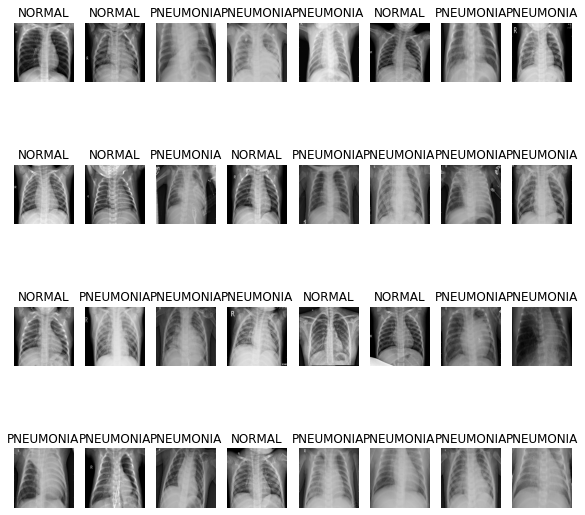

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])        
        if label_batch[n]:

            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### Step 4. CNN 모델링

##### Convolution block 만들기
- Convolution을 2번 후 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결
- Max Pooling

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

##### regularization 기법 적용
- Batch Normalization
- Dropout

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

##### CNN 모델 구축

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Step 5. 데이터 imbalance 처리
- Weight balancing : training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법
- Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원

- weight_for_0은 'Normal' 이미지에 사용할 weight를 세팅
- weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅
- 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### Step 6. 모델 훈련

- 위에서 만들었던 모델 함수인 build_model()을 model에 선언
- 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss 사용
- optimizer : 'adam'
- 성과에 측정 metrics : 'accuracy', 'precision', 'recall'

- 훈련 변경할 경우, loss 함수는 변경하기 어렵고, optimizer나 learning rate 변경 가능

- optimizer='adam' => optimizer=Adam(learning_rate=0.0005)로 변경 (adam의 default learning_rate = 0.001)

In [24]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [25]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
130/130 [==============================] - 68s 407ms/step - loss: 0.4909 - accuracy: 0.7260 - precision: 0.9323 - recall: 0.6811 - val_loss: 0.6761 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 53s 407ms/step - loss: 0.2362 - accuracy: 0.8940 - precision: 0.9812 - recall: 0.8744 - val_loss: 0.5971 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/15
130/130 [==============================] - 54s 418ms/step - loss: 0.1925 - accuracy: 0.9248 - precision: 0.9780 - recall: 0.9195 - val_loss: 0.7218 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/15
130/130 [==============================] - 54s 416ms/step - loss: 0.1608 - accuracy: 0.9406 - precision: 0.9818 - recall: 0.9377 - val_loss: 0.8624 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/15
130/130 [==============================] - 55s 427ms/step - loss: 0.1486 - accura

### Step 7. 결과 확인과 시각화

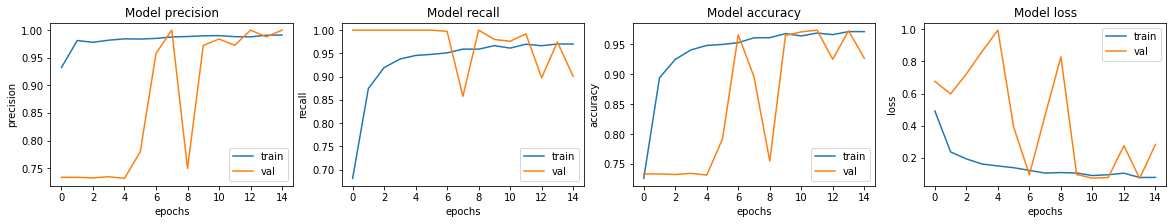

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 7s 309ms/step - loss: 0.3886 - accuracy: 0.8910 - precision: 0.8710 - recall: 0.9692
Loss: 0.3886309266090393,
Accuracy: 0.8910256624221802,
Precision: 0.8709677457809448,
Recall: 0.9692307710647583
